In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
# 准备数据
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# 将数据划分成训练集、验证集、测试集
train_set, val_set = random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
len(train_set), len(val_set), len(test_set)

(50000, 10000, 10000)

In [3]:
# 构建数据读取器
train_loader = DataLoader(train_set, batch_size=500, shuffle=True)
val_loader = DataLoader(val_set, batch_size=500, shuffle=True)
test_loader = DataLoader(test_set, batch_size=500, shuffle=True)

In [4]:
# 获取一个批量的数据
x, y = next(iter(train_loader))
x.shape, y.shape, x.view(x.shape[0], -1).shape

(torch.Size([500, 1, 28, 28]), torch.Size([500]), torch.Size([500, 784]))

In [5]:
# 两种常见的实现方式
## 自由度更大的实现方式
class MLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 30)
        self.hidden2 = nn.Linear(30, 20)
        self.out = nn.Linear(20, 10)

    def forward(self, x):
        '''
        多层感知器的向前传播
        参数
        ----
        x ：torch.FloatTensor，形状为(B, 784)，其中B表示批量数据的大小
        '''
        x = F.sigmoid(self.hidden1(x))  # (B, 30)
        x = F.sigmoid(self.hidden2(x))  # (B, 20)
        x = self.out(x)                 # (B, 10)
        return x

model = MLP()

## 更简洁的实现方式
model = nn.Sequential(
    nn.Linear(784, 30), nn.Sigmoid(),
    nn.Linear( 30, 20), nn.Sigmoid(),
    nn.Linear( 20, 10)
)

In [6]:
eval_iters = 10

def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['val'] = _loss(model, val_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    accuracy = []
    data_iter = iter(data_loader)
    for k in range(eval_iters):
        inputs, labels = next(data_iter)
        B, C, H, W = inputs.shape
        # 将数据转换成模型输入要求的形状
        # 也可以用如下的命令来完成：inputs.view(-1, 784)
        logits = model(inputs.view(B, -1))
        # 计算模型损失
        loss.append(F.cross_entropy(logits, labels))
        # 计算预测的准确率
        _, predicted = torch.max(logits, 1)
        accuracy.append((predicted == labels).sum() / B)
    re = {
        'loss': torch.tensor(loss).mean().item(),
        'accuracy': torch.tensor(accuracy).mean().item()
    }
    return re

In [7]:
def train_mlp(model, optimizer, data_loader, epochs=10, penalty=[]):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            B, C, H, W = inputs.shape
            # 将数据转换成模型输入要求的形状
            # 也可以用如下的命令来完成：inputs.view(-1, 784)
            logits = model(inputs.view(B, -1))
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            # 增加惩罚项
            for p in penalty:
                loss += p(model)
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]["loss"]:.4f}'
        val_loss = f'val loss {stats["val"]["loss"]:.4f}'
        test_loss = f'test loss {stats["test"]["loss"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {val_loss}, {test_loss}')
        train_acc = f'train acc {stats["train"]["accuracy"]:.4f}'
        val_acc = f'val acc {stats["val"]["accuracy"]:.4f}'
        test_acc = f'test acc {stats["test"]["accuracy"]:.4f}'
        print(f'{"":>10}{train_acc}, {val_acc}, {test_acc}')
    return lossi

In [8]:
stats = {}

In [9]:
# 模型参数初始化
# nn.init下面的函数都自动跑在torch.no_grad()的模式下
for m in model:
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('sigmoid'))
        nn.init.zeros_(m.bias)

# 使用最经典的标准随机梯度下降法
stats['mlp'] = train_mlp(model, optim.SGD(model.parameters(), lr=0.001), train_loader)

epoch  0: train loss 2.3778, val loss 2.3783, test loss 2.3740
          train acc 0.1050, val acc 0.1042, test acc 0.1018
epoch  1: train loss 2.3652, val loss 2.3679, test loss 2.3587
          train acc 0.0998, val acc 0.1054, test acc 0.0996
epoch  2: train loss 2.3579, val loss 2.3572, test loss 2.3564
          train acc 0.0958, val acc 0.1048, test acc 0.1018
epoch  3: train loss 2.3514, val loss 2.3545, test loss 2.3452
          train acc 0.0972, val acc 0.0988, test acc 0.0960
epoch  4: train loss 2.3378, val loss 2.3427, test loss 2.3362
          train acc 0.0906, val acc 0.0944, test acc 0.0936
epoch  5: train loss 2.3339, val loss 2.3347, test loss 2.3252
          train acc 0.0892, val acc 0.0966, test acc 0.0926
epoch  6: train loss 2.3239, val loss 2.3264, test loss 2.3260
          train acc 0.0952, val acc 0.0940, test acc 0.0946
epoch  7: train loss 2.3136, val loss 2.3153, test loss 2.3201
          train acc 0.1096, val acc 0.1084, test acc 0.1008
epoch  8: train 

In [10]:
# 使用更高效的激活函数搭建模型
model1 = nn.Sequential(
    nn.Linear(784, 30), nn.ReLU(),
    nn.Linear( 30, 20), nn.ReLU(),
    nn.Linear( 20, 10)
)

# 模型参数初始化
# nn.init下面的函数都自动跑在torch.no_grad()的模式下
for m in model1:
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias)
    
stats['mlp_relu'] = train_mlp(model1, optim.SGD(model1.parameters(), lr=0.001), train_loader)

epoch  0: train loss 2.3180, val loss 2.3065, test loss 2.3033
          train acc 0.1066, val acc 0.1070, test acc 0.1136
epoch  1: train loss 2.2322, val loss 2.2220, test loss 2.2221
          train acc 0.1354, val acc 0.1302, test acc 0.1322
epoch  2: train loss 2.1533, val loss 2.1500, test loss 2.1490
          train acc 0.1596, val acc 0.1600, test acc 0.1590
epoch  3: train loss 2.1046, val loss 2.0999, test loss 2.0873
          train acc 0.1816, val acc 0.1822, test acc 0.1810
epoch  4: train loss 2.0356, val loss 2.0395, test loss 2.0476
          train acc 0.2152, val acc 0.2214, test acc 0.2074
epoch  5: train loss 1.9938, val loss 1.9933, test loss 1.9784
          train acc 0.2594, val acc 0.2526, test acc 0.2622
epoch  6: train loss 1.9594, val loss 1.9515, test loss 1.9479
          train acc 0.2754, val acc 0.2894, test acc 0.2916
epoch  7: train loss 1.9213, val loss 1.9103, test loss 1.9047
          train acc 0.3144, val acc 0.3194, test acc 0.3194
epoch  8: train 

In [11]:
# 在模型中增加归一化层，可加速训练过程
model2 = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear(             20, 10)
)

# 模型参数初始化
# nn.init下面的函数都自动跑在torch.no_grad()的模式下
for m in model2:
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))

stats['mlp_relu_layer_norm'] = train_mlp(model2, optim.SGD(model2.parameters(), lr=0.001), train_loader)

epoch  0: train loss 2.2938, val loss 2.2973, test loss 2.2647
          train acc 0.1716, val acc 0.1746, test acc 0.1806
epoch  1: train loss 2.1120, val loss 2.1006, test loss 2.0767
          train acc 0.2590, val acc 0.2646, test acc 0.2808
epoch  2: train loss 1.9710, val loss 1.9687, test loss 1.9488
          train acc 0.3556, val acc 0.3530, test acc 0.3668
epoch  3: train loss 1.8826, val loss 1.8678, test loss 1.8574
          train acc 0.4090, val acc 0.4240, test acc 0.4240
epoch  4: train loss 1.7792, val loss 1.7858, test loss 1.7711
          train acc 0.4660, val acc 0.4664, test acc 0.4734
epoch  5: train loss 1.7369, val loss 1.7219, test loss 1.7008
          train acc 0.4790, val acc 0.4942, test acc 0.5104
epoch  6: train loss 1.6658, val loss 1.6496, test loss 1.6290
          train acc 0.5246, val acc 0.5264, test acc 0.5470
epoch  7: train loss 1.6208, val loss 1.6038, test loss 1.5784
          train acc 0.5484, val acc 0.5470, test acc 0.5704
epoch  8: train 

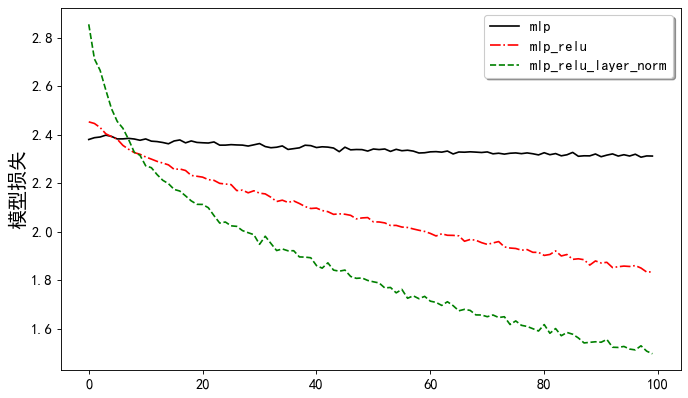

In [12]:
# 展示3种模型的损失下降曲线
fig = plt.figure(figsize=(10, 6), dpi=80)
# 解决中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
plt.ylabel('模型损失', fontsize=18)
style = ['k', 'r-.', 'g--']
for i, l in enumerate(['mlp', 'mlp_relu', 'mlp_relu_layer_norm']):
    _l = torch.tensor(stats[l]).view(-1, 10).mean(1)
    plt.plot(_l.numpy(), style[i], label=l)
legend = plt.legend(shadow=True)
plt.savefig("mnist_mlp_loss.png", dpi=200)
plt.show()

In [13]:
# 模型会遭遇比较严重的过拟合问题
model2 = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear(             20, 10)
)

_ = train_mlp(model2, optim.Adam(model2.parameters(), lr=0.01), train_loader)

epoch  0: train loss 0.2021, val loss 0.2017, test loss 0.2014
          train acc 0.9420, val acc 0.9372, test acc 0.9430
epoch  1: train loss 0.1160, val loss 0.1818, test loss 0.1695
          train acc 0.9644, val acc 0.9454, test acc 0.9488
epoch  2: train loss 0.1054, val loss 0.1394, test loss 0.1379
          train acc 0.9694, val acc 0.9556, test acc 0.9596
epoch  3: train loss 0.1051, val loss 0.1511, test loss 0.1387
          train acc 0.9658, val acc 0.9534, test acc 0.9584
epoch  4: train loss 0.0837, val loss 0.1261, test loss 0.1376
          train acc 0.9770, val acc 0.9624, test acc 0.9620
epoch  5: train loss 0.0682, val loss 0.1265, test loss 0.1214
          train acc 0.9800, val acc 0.9622, test acc 0.9656
epoch  6: train loss 0.0871, val loss 0.1341, test loss 0.1344
          train acc 0.9722, val acc 0.9602, test acc 0.9588
epoch  7: train loss 0.0652, val loss 0.1211, test loss 0.1327
          train acc 0.9812, val acc 0.9596, test acc 0.9612
epoch  8: train 

In [14]:
# 展示模型评估模式和训练模式的差别
m = nn.Dropout(0.5)
x = torch.randn(5)
# 创建之后，模型处于训练模式
print(x, m(x))
# 模型处于评估模式
m.eval()
print(x, m(x))
# 模型处于训练模式
m.train()
print(x, m(x))

tensor([-0.7424,  0.6917, -1.3143,  1.0491,  0.8641]) tensor([-0.0000, 0.0000, -0.0000, 2.0982, 0.0000])
tensor([-0.7424,  0.6917, -1.3143,  1.0491,  0.8641]) tensor([-0.7424,  0.6917, -1.3143,  1.0491,  0.8641])
tensor([-0.7424,  0.6917, -1.3143,  1.0491,  0.8641]) tensor([-0.0000, 1.3833, -0.0000, 0.0000, 0.0000])


In [15]:
# 加入dropout之后会减轻过拟合的问题
model3 = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(             20, 10)
)

_ = train_mlp(model3, optim.Adam(model3.parameters(), lr=0.01), train_loader, epochs=50)

epoch  0: train loss 0.2624, val loss 0.2747, test loss 0.2760
          train acc 0.9218, val acc 0.9192, test acc 0.9218
epoch  1: train loss 0.2212, val loss 0.2136, test loss 0.2235
          train acc 0.9366, val acc 0.9396, test acc 0.9404
epoch  2: train loss 0.1815, val loss 0.1791, test loss 0.2103
          train acc 0.9482, val acc 0.9474, test acc 0.9390
epoch  3: train loss 0.1586, val loss 0.1938, test loss 0.2001
          train acc 0.9564, val acc 0.9434, test acc 0.9466
epoch  4: train loss 0.1583, val loss 0.1809, test loss 0.1635
          train acc 0.9536, val acc 0.9468, test acc 0.9502
epoch  5: train loss 0.1400, val loss 0.1830, test loss 0.1716
          train acc 0.9602, val acc 0.9460, test acc 0.9550
epoch  6: train loss 0.1354, val loss 0.1662, test loss 0.1716
          train acc 0.9608, val acc 0.9516, test acc 0.9508
epoch  7: train loss 0.1332, val loss 0.1840, test loss 0.1861
          train acc 0.9590, val acc 0.9438, test acc 0.9486
epoch  8: train 

In [16]:
# 定义l1和l2惩罚项
def l1_loss(model, weight):
    w = torch.cat([p.view(-1) for p in model.parameters()])
    return weight * torch.abs(w).sum()

def l2_loss(model, weight):
    w = torch.cat([p.view(-1) for p in model.parameters()])
    return weight * torch.square(w).sum()

In [17]:
# 使用l2惩罚性
model2 = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear(             20, 10)
)

p2 = lambda m: l2_loss(m, 0.001)
_ = train_mlp(model2, optim.Adam(model2.parameters(), lr=0.01), train_loader, penalty=[p2])

epoch  0: train loss 0.2159, val loss 0.2189, test loss 0.2249
          train acc 0.9408, val acc 0.9360, test acc 0.9366
epoch  1: train loss 0.1815, val loss 0.1961, test loss 0.1797
          train acc 0.9482, val acc 0.9438, test acc 0.9462
epoch  2: train loss 0.1400, val loss 0.1786, test loss 0.1547
          train acc 0.9626, val acc 0.9452, test acc 0.9560
epoch  3: train loss 0.1465, val loss 0.1666, test loss 0.1588
          train acc 0.9582, val acc 0.9510, test acc 0.9554
epoch  4: train loss 0.1555, val loss 0.1726, test loss 0.1639
          train acc 0.9530, val acc 0.9502, test acc 0.9518
epoch  5: train loss 0.1397, val loss 0.1606, test loss 0.1441
          train acc 0.9588, val acc 0.9490, test acc 0.9558
epoch  6: train loss 0.1506, val loss 0.1638, test loss 0.1609
          train acc 0.9538, val acc 0.9494, test acc 0.9568
epoch  7: train loss 0.1317, val loss 0.1556, test loss 0.1438
          train acc 0.9634, val acc 0.9544, test acc 0.9578
epoch  8: train 